In [1]:
!pip install -q sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import sqlite3

SQLname = "/content/drive/MyDrive/ESP/ESP.db"


conn = sqlite3.connect(SQLname)



query1 = "SELECT * FROM df_Viscosity;"
data = pd.read_sql_query(query1, conn)


# Selecting 4 columns only
query2 = (
    "SELECT QL_bpd, RPM, TargetVISL_cp, Head_ft "
    "FROM df_viscosity "
    "WHERE Pump LIKE 'P100%' "
    # "AND (Test LIKE 'SGL' OR Test LIKE 'Viscosity') "
    "ORDER BY RPM, TargetVISL_cp;"
)
df_data = pd.read_sql_query(query2, conn)

conn.close()
# Popping Head_ft column in order to train model
#y_train = df_data.pop("Head_ft")
#print(y_train)

df_data.head()


,QL_bpd,RPM,TargetVISL_cp,Head_ft
0,639.156,2400,10.0,26.228784
1,1273.992,2400,10.0,26.124187
2,1910.466,2400,10.0,25.782991
3,2543.340,2400,10.0,25.235809
4,3180.630,2400,10.0,24.610803


In [6]:
train_dataset = df_data.sample(frac=0.7, random_state=0)
test_dataset = df_data.drop(train_dataset.index)

print("Train dataset shape:", train_dataset.shape)
print("Test dataset shape:", test_dataset.shape)

y_train = train_dataset.pop("Head_ft")
y_test = test_dataset.pop("Head_ft")

Train dataset shape: (273, 4)
Test dataset shape: (117, 4)


In [7]:
NUMERIC_COLUMNS = ["QL_bpd", "RPM", "TargetVISL_cp"]
feature_columns = []

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


[NumericColumn(key='QL_bpd', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='RPM', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='TargetVISL_cp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [8]:
def make_input_fn(data_df, label_df, num_epochs=1000, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(train_dataset, y_train)
eval_input_fn = make_input_fn(test_dataset, y_test, num_epochs=1, shuffle=False)

In [9]:
# Create a linear classifier
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns)

# Train the classifier
linear_est.train(train_input_fn)
# Evaluate the model
result = linear_est.evaluate(eval_input_fn)

# Print the accuracy
print(result)

Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


{'average_loss': 22.366102, 'label/mean': 34.36778, 'loss': 22.868977, 'prediction/mean': 35.163933, 'global_step': 9000}


Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


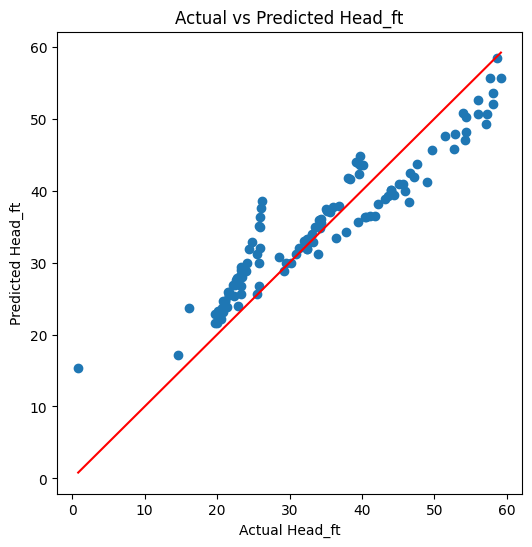

In [13]:
# Make predictions on the test set
predictions = linear_est.predict(eval_input_fn)
predicted_values = [pred['predictions'][0] for pred in predictions]

# Scatter plot of actual vs predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, predicted_values)
plt.xlabel('Actual Head_ft')
plt.ylabel('Predicted Head_ft')
plt.title('Actual vs Predicted Head_ft')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.show()